In [26]:
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
from torch.utils.data import Dataset
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import pandas as pd 


import torch.nn.functional as F

## Read data

In [27]:
train_data = pd.read_csv('../Data/training.csv')
test_data = pd.read_csv('../Data/test.csv')
id_lookup_data = pd.read_csv('../Data/IdLookupTable.csv')

In [28]:
train_data = train_data.dropna()

train_data.shape

(2140, 31)

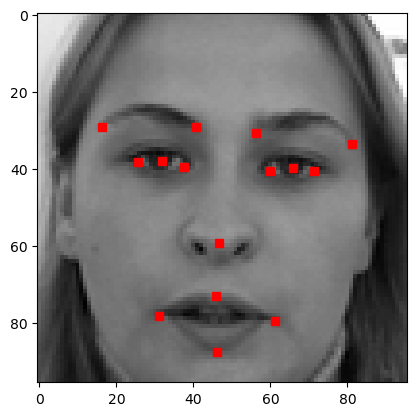

In [29]:
def get_image_and_keypoints(series):
    image = series['Image']
    image = np.fromstring(image, sep=' ').reshape([96, 96]) / 255.0
    keypoints = pd.DataFrame(series).drop(['Image'], axis=0).values.reshape([15, 2])
    return image, keypoints

def get_image_and_keypoints_by_id(train_data, id):
    series = train_data.iloc[id]
    return get_image_and_keypoints(series)


def show_image_with_keypoints(series):
    image, keypoints = get_image_and_keypoints(series)
    plt.imshow(image, cmap='gray')
    plt.plot(keypoints[:, 0], keypoints[:, 1], 'rs')


def show_image_with_keypoints_by_id(train_data, id):
    series = train_data.iloc[id]
    show_image_with_keypoints(series)
    
show_image_with_keypoints_by_id(train_data, 168)

## Augmentation

1. flip
2. gaussian noise (gaussianblur())
3. resize

In [30]:
def data_for_aug(file_name):
    labels=[file_name.iloc[i].values[0:30] for i in range(len(file_name))]
    inputs=[file_name.iloc[i].values[30:31] for i in range(len(file_name))]
    
    inputs = [(i[0].split()) for i in inputs]
    inputs = [[int(i) for i in j] for j in inputs] 
    inputs = [np.reshape(i, (96,96)) for i in inputs]
    inputs = torch.tensor(inputs, dtype=torch.float)
    #inputs = [np.expand_dims(i,0) for i in inputs]
    
    return labels, inputs



In [31]:
keypoints, images = data_for_aug(train_data)

In [32]:
def delete_multiple_element(list_object, indices):
    indices = sorted(indices, reverse=True)
    for idx in indices:
        if idx < len(list_object):
            list_object.pop(idx)

In [33]:
#flipped data

sample_image_index = 168

def left_right_flip(images, keypoints):
    
    flipper = transforms.RandomHorizontalFlip(p = 0.5)
    flipped_images = [flipper(image) for image in images]
    
    flpd_imgs = [1 if torch.equal(images[i],flipped_images[i]) == False else 0 for i in range(len(images))]
    
    flipped_keypoints = []
    print(flpd_imgs[:5])
    list_of_indices = []
    k = 0
    for idx, sample_keypoints in enumerate(keypoints):
        if flpd_imgs[k] == 1:
            flipped_keypoints.append([96.-coor if idx%2==0 else coor for idx,coor in enumerate(sample_keypoints)])
            # Subtract only X co-ordinates of keypoints from 96 for horizontal flipping
        else:
            list_of_indices.append(k)
        k += 1
    
    delete_multiple_element(flipped_images, list_of_indices)
    
    flipped_keypoints = torch.tensor(flipped_keypoints, dtype=torch.float)
    #flipped_images = torch.tensor(flipped_images, dtype=torch.float)
    return flipped_images, flipped_keypoints



flipped_train_images, flipped_train_keypoints = left_right_flip(images, keypoints)

#train_images = np.concatenate((images, flipped_train_images))
#train_keypoints = np.concatenate((keypoints, flipped_train_keypoints))
#fig, axis = plt.subplots()
#plot_sample(flipped_train_images[sample_image_index], flipped_train_keypoints[sample_image_index], axis, "Horizontally Flipped") 
    



[0, 1, 0, 0, 0]


In [12]:
len(flipped_train_keypoints)
len(flipped_train_images)

1079

In [34]:
def plot_sample(image, keypoint,title):
    image = image.reshape(96,96)
    fig, axis = plt.subplots()
    axis.imshow(image, cmap='gray')
    axis.scatter(keypoint[0::2], keypoint[1::2], marker='x', s=20)
    plt.title(title)

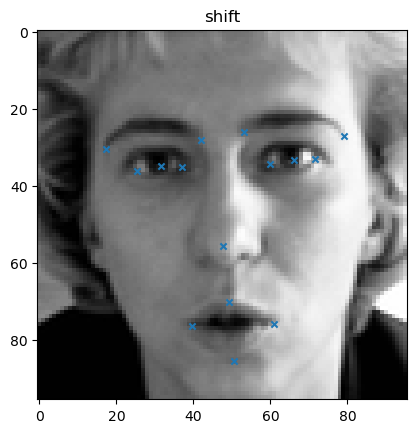

In [35]:
plot_sample(flipped_train_images[0],flipped_train_keypoints[0], "shift" )

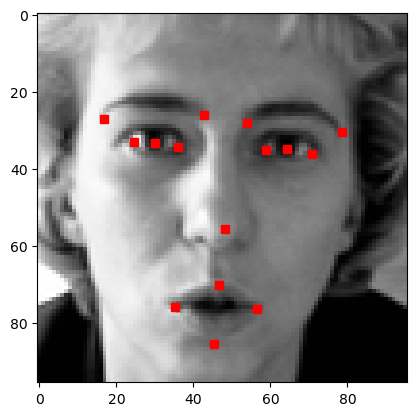

In [36]:
show_image_with_keypoints_by_id(train_data, 1)